# Single cell proteogenomics
---
## Input data

This workbook is based on the work posted in this repository: https://github.com/CellProfiling/SingleCellProteogenomics.

Please download the input folder, which is located here (~650 MB): https://drive.google.com/file/d/149ICTtieYjuKWZoLwRLzimwff0n6eWqw/view?usp=sharing.

Place this folder in the same directory as this file.

## Imaging proteomics

The first dataset that you will use is an imaging proteomic dataset. This dataframe contains the postprocessing results (using CellProfiler) for thousands of images containing four channels (colors) that contain information about a protein of interest, a marker channel (microtubules), and two fluorescence markers that precisely characterize the cell cycle time for each individual cell.

The dataframe contains information for each individual cell in this dataset (~200,000 cells). One particular challenge of this dataset is that each image (and thus each cell in each image) contains information for only one protein. This is in stark comparison to techniques like single-cell RNA sequencing, which contains measurements for a full complement genes (~13,000) in each cell. Therefore, this single-cell proteomic data can be considered _very sparse_ data.

In [52]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.mixture
import decimal
import scipy.optimize
from copy import deepcopy
import copy
plt.rcParams['pdf.fonttype'], plt.rcParams['ps.fonttype'], plt.rcParams['savefig.dpi'] = 42, 42, 300 #Make PDF text readable

# EMPTYWELLS: These wells on the last plate didn't have cells; the segmentation algorithm still annotated some, so remove them
EMPTYWELLS = set(["B11_6745","C11_6745","D11_6745","E11_6745","F11_6745","G11_6745","H11_6745",
    "A12_6745","B12_6745","C12_6745","D12_6745","E12_6745","F12_6745","G12_6745"]) 

# MIN_CELL_COUNT: Minimum number of cells per sample required for cell cycle analysis with pseudotime
MIN_CELL_COUNT = 60 

# Let's make some output folders
if not os.path.exists("output/"): os.mkdir("output/")
if not os.path.exists("output/pickles/"): os.mkdir("output/pickles/")
if not os.path.exists("figures/"): os.mkdir("figures/")

In [53]:
# Load the raw imaging proteomic dataframe
print("reading raw protein IF data")
my_df1 = pd.read_csv("input/ProteinData/FucciDataFirstPlates.csv.gz")
my_df2 = pd.read_csv("input/ProteinData/FucciDataSecondPlates.csv.gz")
my_df = pd.concat((my_df1, my_df2), sort=True)
print("loaded raw data")



reading raw protein IF data
loaded raw data


In [54]:
# Output column information
print(",".join(my_df.columns))
print(my_df.shape)
my_df.head()

AreaShape_Area,AreaShape_Perimeter,Area_cell,Area_cyto,CC,Children_FilteredG1S_Count,Children_FilteredG1_Count,Children_FilteredSG2_Count,ImageNumber,Integrated_ab_cell,Integrated_ab_cyto,Integrated_green_cell,Integrated_green_cyto,Integrated_mt_cell,Integrated_mt_cyto,Integrated_red_cell,Integrated_red_cyto,Intensity_IntegratedIntensity_CorrResizedGreenFUCCI,Intensity_IntegratedIntensity_CorrResizedRedFUCCI,Intensity_IntegratedIntensity_ResizedAb,Intensity_IntegratedIntensity_Resizedmt,Intensity_MeanIntensity_CorrResizedGreenFUCCI,Intensity_MeanIntensity_CorrResizedRedFUCCI,Intensity_MeanIntensity_ResizedAb,Intensity_MeanIntensity_Resizedmt,Intensity_MedianIntensity_CorrResizedGreenFUCCI,Intensity_MedianIntensity_CorrResizedRedFUCCI,Intensity_MedianIntensity_ResizedAb,Intensity_MedianIntensity_Resizedmt,Mean_Green_Fucci_Cyto,Mean_Green_Fucci_cell,Mean_Red_Fucci_Cyto,Mean_Red_Fucci_cell,Mean_ab_Cyto,Mean_ab_cell,Mean_mt_Cyto,Mean_mt_cell,Median_Green_Fucci_Cyto,Median_Green_Fucci_cell,

,AreaShape_Area,AreaShape_Perimeter,Area_cell,Area_cyto,CC,Children_FilteredG1S_Count,Children_FilteredG1_Count,Children_FilteredSG2_Count,ImageNumber,Integrated_ab_cell,...,perimeter_cyto,plate,ratio,site,well,well_plate,well_plate_imagenb,z.1,z.2,z.3
0,2873,226.840,12663,10048,G1,0,1,0,1,512.820186,...,842.608,55185977,4.407588,s1,A01,A01_55185977,A01_55185977_1,7.830000e-13,0.997837,0.002163
1,4132,307.458,22795,18989,G1,0,1,0,1,772.886203,...,1076.448,55185977,5.516699,s1,A01,A01_55185977,A01_55185977_1,2.170000e-08,0.723075,0.276925
2,3322,259.184,18026,14985,G1,0,1,0,1,571.807960,...,1122.664,55185977,5.426249,s1,A01,A01_55185977,A01_55185977_1,2.300000e-13,0.998563,0.001437
3,3785,307.738,25471,22021,G1,0,1,0,1,598.421343,...,1099.658,55185977,6.729458,s1,A01,A01_55185977,A01_55185977_1,4.818490e-04,0.008276,0.991242
4,3881,267.324,23035,19456,G1,0,1,0,1,710.050136,...,1378.988,55185977,5.935326,s1,A01,A01_55185977,A01_55185977_1,1.030000e-09,0.665294,0.334706


## Description of dataframe

### Size of the dataframe
**This dataframe has information for each of hundreds of cells for ~1200 proteins.**
Note there are 637,104 segmented objects above. That's a lot of cells! Pretty cool stuff.

### Dataframe columns
#### Unique identifiers
* ImageNumber:
    * Unique identifier for image
* ObjectNumber:
    * Unique identifier for the object within the image
* plate:
    * Images were collected for cells seeded in 96-well plates; this is the plate identifier, which was important for batch correction
* well:
    * This is the well within the plate
* well_plate:
    * Concatenated identifiers
* well_plate_imagenb:
    * Concatenated identifiers

#### Cell shape and segmentation
* AreaShape_Area,AreaShape_Perimeter,Area_cell,Area_cyto,perimeter_cell,perimeter_cyto:
    * area of the cell, circumference of the cell, area of the cytoplasm (minus nuclear segmented area)
* Z1prob,Z2prob,Z3prob,z.1,z.2,z.3,a,classification,d,d1
    * These pertain to the segmentation of cells
    
#### Intensities
* Integrated_ab_cell,Integrated_ab_cyto,Integrated_green_cell,Integrated_green_cyto,Integrated_mt_cell,Integrated_mt_cyto,Integrated_red_cell,Integrated_red_cyto:
    * Integrated intensities of **protein of interest (ab)**
    * Integrated intensity of **geminin-GFP construct (green)**
    * Integrated intensity of **CDT1-RFT construct (red)**
    * Integrated intensity of the interal control of **microtubules (mt)**
    * These intensities are split between the **cell** and **cytoplasm**
* Mean_Green_Fucci_Cyto,Mean_Green_Fucci_cell,Mean_Red_Fucci_Cyto,Mean_Red_Fucci_cell,Mean_ab_Cyto,Mean_ab_cell,Mean_mt_Cyto,Mean_mt_cell:
    * Similar to above but mean intensity
* Median_Green_Fucci_Cyto,Median_Green_Fucci_cell,Median_Red_Fucci_Cyto,Median_Red_Fucci_cell,Median_ab_Cyto,Median_ab_cell,Median_mt_Cyto,Median_mt_cell:
    * Similar to above but median intensity
* Intensity_IntegratedIntensity_CorrResizedGreenFUCCI,Intensity_IntegratedIntensity_CorrResizedRedFUCCI,Intensity_IntegratedIntensity_ResizedAb,Intensity_IntegratedIntensity_Resizedmt:
    * Similar to above, but for resized areas within CellProfiler
* Intensity_MeanIntensity_CorrResizedGreenFUCCI,Intensity_MeanIntensity_CorrResizedRedFUCCI,Intensity_MeanIntensity_ResizedAb,Intensity_MeanIntensity_Resizedmt:
    * Similar to above, but mean intensity of the pixels within each area
* Intensity_MedianIntensity_CorrResizedGreenFUCCI,Intensity_MedianIntensity_CorrResizedRedFUCCI,Intensity_MedianIntensity_ResizedAb,Intensity_MedianIntensity_Resizedmt:
    * Similar to above but median intensity of the pixels within each area
* log_green,log_red:
    * log intensities of the FUCCI markers; I ended up recalculating these, I believe


## Filtering
There are some important things we need to filter for before proceeding to make sure we're looking at cells and not artifacts:
(3-5 mins)


In [55]:
# Such a large dataframe that I chose to separate out the columns into separate variables when I started this project
# Probably a better way to do that! But it got the job done.
def read_sample_info(df):
    '''Get the metadata for all the samples'''
    plate = np.asarray(df.plate)
    u_plate = np.unique(plate)
    well_plate = np.asarray(df.well_plate)
    imgnb = np.asarray(df.ImageNumber)
    well_plate_imgnb = np.asarray([f"{wp}_{imgnb[i]}" for i,wp in enumerate(well_plate)])
    u_well_plates = np.unique(well_plate)
    ab_objnum = np.asarray(df.ObjectNumber)
    well_plate_imgnb_objnb = np.asarray([f"{wp}_{imgnb[i]}_{ab_objnum[i]}" for i,wp in enumerate(well_plate)])
    area_cell = np.asarray(df.Area_cell)
    area_nuc = np.asarray(df.AreaShape_Area)
    area_cyto = np.asarray(df.Area_cyto)
    name_df = pd.read_csv("input/ProteinData/FucciStainingSummaryFirstPlates.csv")
    wppp1, ensggg1, abbb1, rrrr, cccc1 = list(name_df["well_plate"]), list(name_df["ENSG"]), list(name_df["Antibody"]), list(name_df["Results_final_update"]), list(name_df["Compartment"])
    name_df2 = pd.read_csv("input/ProteinData/FucciStainingSummarySecondPlates.csv")
    wppp2, ensggg2, abbb2, cccc2 = list(name_df2["well_plate"]), list(name_df2["ENSG"]), list(name_df2["Antibody"]), list(name_df2["Compartment"])
    wppp, ensggg, abbb, cccc = wppp1 + wppp2, ensggg1 + ensggg2, abbb1 +  abbb2, cccc1 + cccc2
    ensg_dict = dict([(wppp[i], ensggg[i]) for i in range(len(wppp))])
    ab_dict = dict([(wppp[i], abbb[i]) for i in range(len(wppp))])
    result_dict = dict([(wppp[i], rrrr[i]) for i in range(len(wppp1))])
    compartment_dict = dict([(wppp[i], cccc[i]) for i in range(len(wppp))])
    ENSG = np.asarray([ensg_dict[wp] if wp in ensg_dict else "" for wp in well_plate])
    antibody = np.asarray([ab_dict[wp] if wp in ab_dict else "" for wp in well_plate])
    result = np.asarray([result_dict[wp] if wp in result_dict else "" for wp in well_plate])
    compartment = np.asarray([compartment_dict[wp] if wp in compartment_dict else "" for wp in well_plate])
    return plate, u_plate, well_plate, well_plate_imgnb, well_plate_imgnb_objnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment

def read_sample_data(df):
    '''Read antibody intensity data for each sample and save it to a file for later use.'''
    # Antibody data (mean intensity)
    ab_nuc = df.Intensity_MeanIntensity_ResizedAb
    ab_cyto = df.Mean_ab_Cyto
    ab_cell = df.Mean_ab_cell
    mt_cell = df.Mean_mt_cell

    # Fucci data (mean intensity)
    green_fucci = np.asarray(df.Intensity_MeanIntensity_CorrResizedGreenFUCCI)
    red_fucci = np.asarray(df.Intensity_MeanIntensity_CorrResizedRedFUCCI)

    return ab_nuc, ab_cyto, ab_cell, mt_cell, green_fucci, red_fucci

def previous_results(u_well_plates, result_dict, ensg_dict, ab_dict):
    '''Process the results metadata into lists of previously annotated CCD proteins'''
    wp_ensg = np.asarray([ensg_dict[wp] if wp in ensg_dict else "" for wp in u_well_plates])
    wp_ab = np.asarray([ab_dict[wp] if wp in ab_dict else "" for wp in u_well_plates])
    wp_prev_ccd = np.asarray([wp in result_dict and result_dict[wp].startswith("ccd") for wp in u_well_plates])
    wp_prev_notccd = np.asarray([wp in result_dict and result_dict[wp].startswith("notccd") for wp in u_well_plates])
    wp_prev_negative = np.asarray([wp in result_dict and result_dict[wp].startswith("negative") for wp in u_well_plates])
    prev_ccd_ensg = wp_ensg[wp_prev_ccd]
    prev_notccd_ensg = wp_ensg[wp_prev_notccd]
    prev_negative_ensg = wp_ensg[wp_prev_negative]
    
    return wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg

In [56]:
plate, u_plate, well_plate, well_plate_imgnb, well_plate_imgnb_objnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = read_sample_info(my_df)

print(f"{len(my_df)}: number of cells before filtering empty wells")
my_df = my_df[~my_df.well_plate.isin(EMPTYWELLS)]
print(f"{len(my_df)}: number of cells after filtering empty wells")

my_df_filtered = my_df
print("filtering out of focus")
oof = pd.read_csv("input/ProteinData/OutOfFocusImages.txt", header=None)[0]
well_plate = np.asarray(my_df_filtered.well_plate)
imgnb = np.asarray(my_df_filtered.ImageNumber)
well_plate_imgnb = np.asarray([f"{wp}_{imgnb[i]}" for i,wp in enumerate(well_plate)])
print(f"{len(my_df_filtered)}: number of cells before filtering out of focus images")
my_df_filtered = my_df_filtered[~np.isin(well_plate_imgnb, oof)]
print(f"{len(my_df_filtered)}: number of cells after filtering out of focus images")
print("finished filtering")

print("filtering negative staining")
new_data_or_nonnegative_stain = [wp not in result_dict or (not result_dict[wp].lower().startswith("negative") and not wp.startswith("H12")) for wp in my_df_filtered.well_plate]
print(f"{len(my_df_filtered)}: number of cells before filtering negative staining from first batch")
my_df_filtered = my_df_filtered[new_data_or_nonnegative_stain]
print(f"{len(my_df_filtered)}: number of cells after filtering negative staining from first batch")
print("finished filtering")
    
print("filtering bad fields of view (negative staining, unspecific, etc)")
filterthese = pd.read_csv("input/ProteinData/FOV_ImgNum_Lookup.csv")
badfov = filterthese["well_plate_imgnb"][(filterthese["UseImage"] == 0)]
well_plate = np.asarray(my_df_filtered.well_plate)
imgnb = np.asarray(my_df_filtered.ImageNumber)
well_plate_imgnb = np.asarray([f"{wp}_{imgnb[i]}" for i,wp in enumerate(well_plate)])
negative_controls = np.asarray([wp.startswith("H12") for wp in well_plate])
print(f"{len(my_df_filtered)}: number of cells before filtering out of focus images")
my_df_filtered = my_df_filtered[~np.isin(well_plate_imgnb, badfov) & ~negative_controls]
print(f"{len(my_df_filtered)}: number of cells after filtering out of focus images")
print("finished filtering")

print("filtering failed antibodies")
failedab = np.genfromtxt("input/ProteinData/RecentlyFailedAntibodies.txt", dtype='str')
print(f"{len(my_df_filtered)}: number of cells before filtering antibodies failed in HPAv19")
my_df_filtered = my_df_filtered[~np.isin([ab_dict[wp] for wp in my_df_filtered.well_plate], failedab)]
print(f"{len(my_df_filtered)}: number of cells after filtering antibodies failed in HPAv19")
print("finished filtering")

print("filtering mitotic proteins")
mitoticab = np.genfromtxt("input/ProteinData/RemoveMitoticAndMicrotubules.txt", dtype='str')
print(f"{len(my_df_filtered)}: number of cells before filtering mitotic/microtubule proteins")
my_df_filtered = my_df_filtered[~np.isin([ab_dict[wp] for wp in my_df_filtered.well_plate], mitoticab)]
print(f"{len(my_df_filtered)}: number of cells after filtering mitotic/microtubule proteins")
print("finished filtering")

my_df_manually_filtered = my_df_filtered

637104: number of cells before filtering empty wells
636296: number of cells after filtering empty wells
filtering out of focus
636296: number of cells before filtering out of focus images
629997: number of cells after filtering out of focus images
finished filtering
filtering negative staining
629997: number of cells before filtering negative staining from first batch
590511: number of cells after filtering negative staining from first batch
finished filtering
filtering bad fields of view (negative staining, unspecific, etc)
590511: number of cells before filtering out of focus images
521702: number of cells after filtering out of focus images
finished filtering
filtering failed antibodies
521702: number of cells before filtering antibodies failed in HPAv19
496035: number of cells after filtering antibodies failed in HPAv19
finished filtering
filtering mitotic proteins
496035: number of cells before filtering mitotic/microtubule proteins
495440: number of cells after filtering mitotic

There are some suspiciously large nuclei!
Note that there is already a cutoff on the smaller side, but we probably need to be careful about not considering those enormous ones.


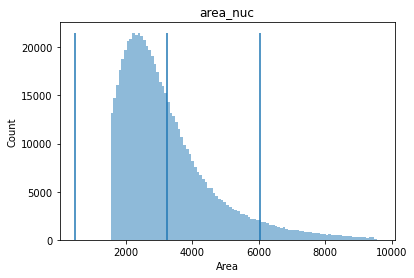

filtering super big nuclei
495440: number of cells before filtering out super big nuclei
467699: number of cells after filtering out super big nuclei
finished filtering on nuclei


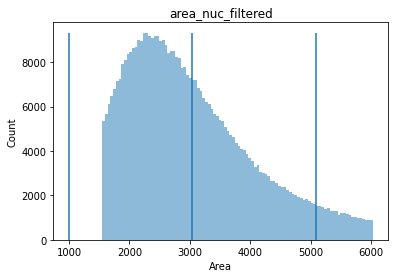

In [57]:
def plot_areas(areas, title):
    '''Histogram for areas of cell/nuc/cytoplasm'''
    bins = plt.hist(areas, bins=100, alpha=0.5)
    plt.vlines(np.mean(areas), 0, np.max(bins[0]))
    plt.vlines(np.mean(areas) - 2 * np.std(areas), 0, np.max(bins[0]))
    plt.vlines(np.mean(areas) + 2 * np.std(areas), 0, np.max(bins[0]))
    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("Area")
    plt.savefig(f"figures/areas{title}.png")
    plt.show()
    plt.close()

print("There are some suspiciously large nuclei!")
print("Note that there is already a cutoff on the smaller side, but we probably need to be careful about not considering those enormous ones.")
area_cell, area_nuc, area_cyto = my_df.Area_cell, my_df.AreaShape_Area, my_df.Area_cyto
# plot_areas(area_cell, "area_cell")
plot_areas(area_nuc, "area_nuc")
# plot_areas(area_cyto, "area_cyto")

upper_nucleus_cutoff = np.mean(area_nuc) + 2 * np.std(area_nuc)

my_df_filtered = my_df_manually_filtered
print("filtering super big nuclei")
cell_passes_nucleus_filter = my_df_filtered.AreaShape_Area < upper_nucleus_cutoff
print(f"{len(my_df_filtered)}: number of cells before filtering out super big nuclei")
my_df_filtered = my_df_filtered[cell_passes_nucleus_filter]
print(f"{len(my_df_filtered)}: number of cells after filtering out super big nuclei")
print("finished filtering on nuclei")

area_cell_filtered, area_nuc_filtered, area_cyto_filtered = my_df_filtered.Area_cell, my_df_filtered.AreaShape_Area, my_df_filtered.Area_cyto
# plot_areas(area_cell_filtered, "area_cell_filtered")
plot_areas(area_nuc_filtered, "area_nuc_filtered")
# plot_areas(area_cyto_filtered, "area_cyto_filtered")

my_df_filtered_areas = my_df_filtered

In [58]:
'''Filter low cell counts per sample'''
my_df_filtered_cellcount = my_df_filtered_areas
well_plate = np.asarray(my_df_filtered_cellcount.well_plate)
u_well_plates = np.unique(my_df_filtered_cellcount.well_plate)
cell_count_dict = {}
for wp in well_plate:
    if wp in cell_count_dict: cell_count_dict[wp] += 1
    else: cell_count_dict[wp] = 1
cell_counts = np.array([cell_count_dict[wp] for wp in well_plate])
print("filtering low cell counts")
my_df_filtered_cellcount = my_df_filtered_cellcount[cell_counts >= MIN_CELL_COUNT]
print(f"{len(my_df_filtered_areas)}: number of cells before filtering out samples with < {MIN_CELL_COUNT} cells")
print(f"{len(my_df_filtered_cellcount)}: number of cells after filtering out samples with < {MIN_CELL_COUNT} cells")
print("finished filtering on cell count")

filtering low cell counts
467699: number of cells before filtering out samples with < 60 cells
466965: number of cells after filtering out samples with < 60 cells
finished filtering on cell count


In [59]:
## Filtering for proteins that are annotated as variable
plate, u_plate, well_plate, well_plate_imgnb, well_plate_imgnb_objnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = read_sample_info(my_df_filtered_cellcount)

my_df_filtered_variation, my_df_filtered_novariation = my_df_filtered_cellcount, my_df_filtered_cellcount
variable_firstbatch = np.asarray([wp in result_dict and not result_dict[wp].replace(" ","").startswith("novariation") for wp in my_df_filtered_cellcount.well_plate])

varann_secondbatch = pd.read_csv("input/ProteinData/SecondBatchVariableLookup.csv")
variable_ann_secondbatch = np.asarray([str(vv).lower().startswith("yes") for vv in varann_secondbatch["IsVariable"]])
variable_wp_secondbatch = np.asarray(varann_secondbatch["well_plate"][variable_ann_secondbatch])
variable_secondbatch = np.isin(my_df_filtered_cellcount.well_plate, variable_wp_secondbatch)

my_df_filtered_variation = my_df_filtered_cellcount[variable_firstbatch | variable_secondbatch]
my_df_filtered_novariation = my_df_filtered_cellcount[~(variable_firstbatch | variable_secondbatch)]
print(f"{len(my_df_filtered_cellcount)}: number of cells before filtering for variation")
print(f"{len(my_df_filtered_variation)}: number of cells in samples with variation")
print(f"{len(my_df_filtered_novariation)}: number of cells in samples without variation")

## Making sure there is compartment information, which were largely ones that were found in mitotic structures (biologically defined as cell cycle dependent, CCD)
wp_iscell = np.asarray([compartment_dict[wp].lower().startswith("cell") if wp in compartment_dict else False for wp in u_well_plates])
wp_isnuc = np.asarray([compartment_dict[wp].lower().startswith("nuc") if wp in compartment_dict else False for wp in u_well_plates])
wp_iscyto = np.asarray([compartment_dict[wp].lower().startswith("cyto") if wp in compartment_dict else False for wp in u_well_plates])

wp_nocompartmentinfo = ~wp_iscell & ~wp_isnuc & ~wp_iscyto
print(f"{sum(wp_nocompartmentinfo)}: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis")
print(f"{len(my_df_filtered_variation)}: number of cells before filtering for compartment information")
my_df_filtered_compartmentvariation = my_df_filtered_variation[~np.isin(my_df_filtered_variation.well_plate, u_well_plates[wp_nocompartmentinfo])]
print(f"{len(my_df_filtered_compartmentvariation)}: number of cells after filtering for compartment information")

466965: number of cells before filtering for variation
267399: number of cells in samples with variation
199566: number of cells in samples without variation
986: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis
267399: number of cells before filtering for compartment information
264260: number of cells after filtering for compartment information


## Now we're done with filtering the dataframe!

* We dropped from over 600,000 segmented objects to 264,260 that we are confident are cells
* Let's look into what we can learn from the intensities of the markers and protein staining in those cells

## Now we need to correct for batch effects

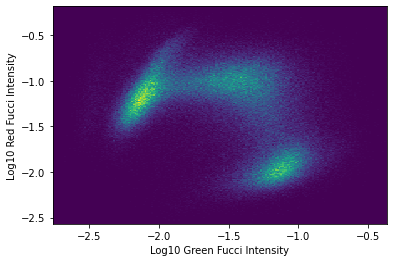

In [60]:
plate, u_plate, well_plate, well_plate_imgnb, well_plate_imgnb_objnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = read_sample_info(
    my_df_filtered_compartmentvariation
)
ab_nuc, ab_cyto, ab_cell, mt_cell, green_fucci, red_fucci = read_sample_data(
    my_df_filtered_compartmentvariation
)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = previous_results(
    u_well_plates, result_dict, ensg_dict, ab_dict
)

plt.hist2d(np.log10(green_fucci), np.log10(red_fucci), bins=200)
plt.xlabel("Log10 Green Fucci Intensity")
plt.ylabel("Log10 Red Fucci Intensity")
plt.savefig("figures/FucciPlotProteinIFData_unfiltered.png")
plt.show()
plt.close()


## Thinking about batch corrections

This looks okay, right? Think again.

Plate: 6717


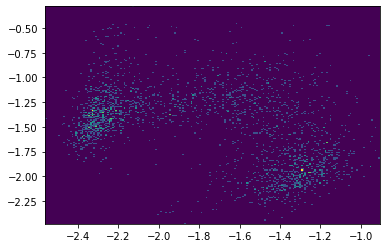

Plate: 6718


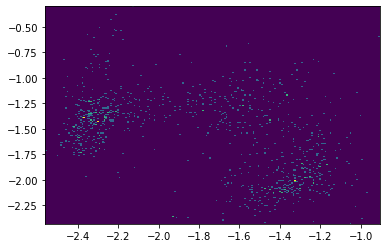

Plate: 6719


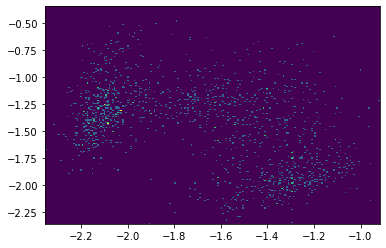

Plate: 6720


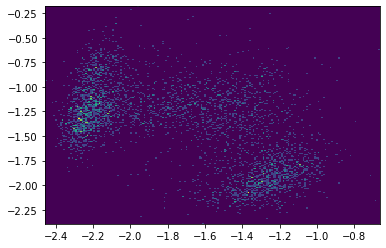

Plate: 6721


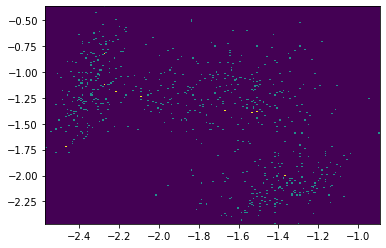

Plate: 6722


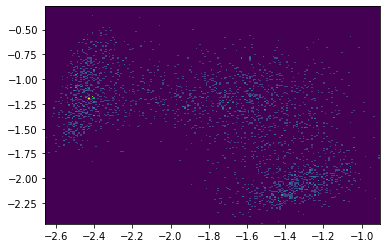

Plate: 6724


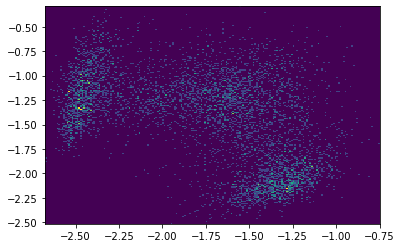

Plate: 6725


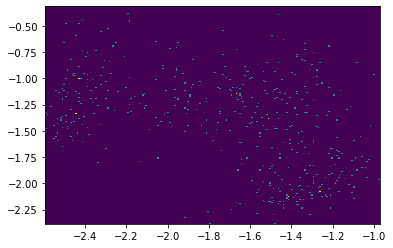

Plate: 6731


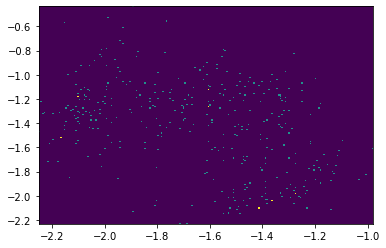

Plate: 6734


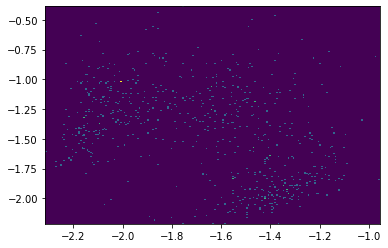

Plate: 6736


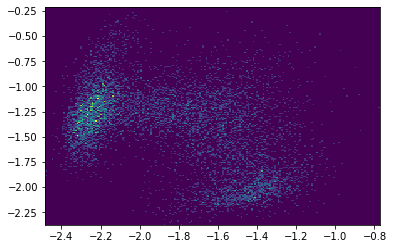

Plate: 6745


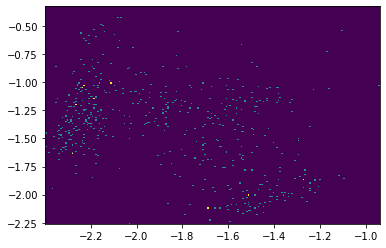

Plate: 55185977


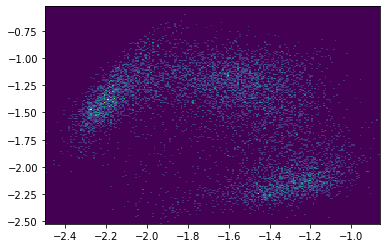

Plate: 55195978


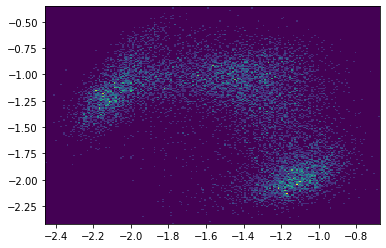

Plate: 55205980


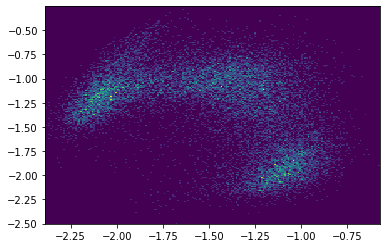

Plate: 55215982


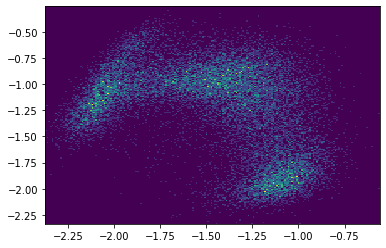

Plate: 55225983


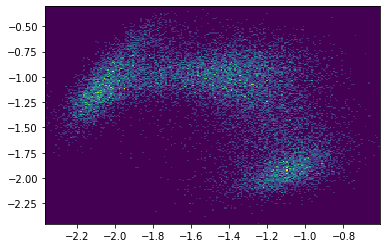

Plate: 55235979


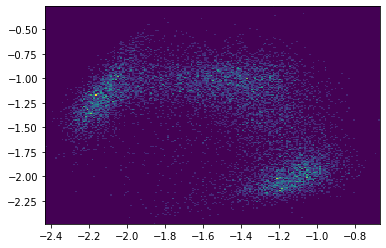

Plate: 55245981


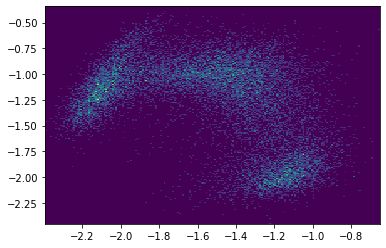

Plate: 55335984


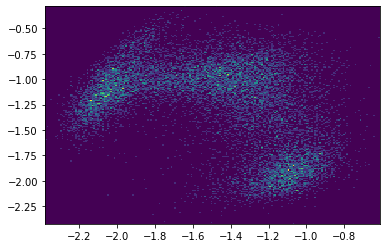

Plate: 55345985


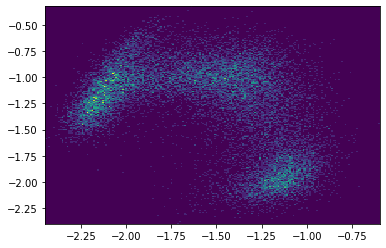

Plate: 55355986


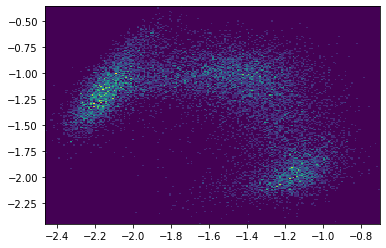

Plate: 55365987


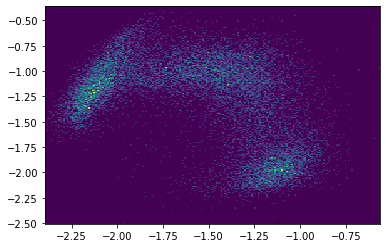

Plate: 55375988


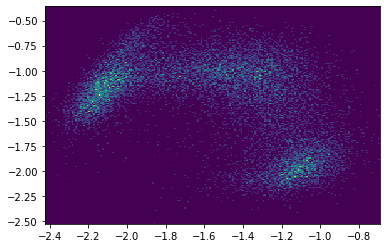

Plate: 55385989


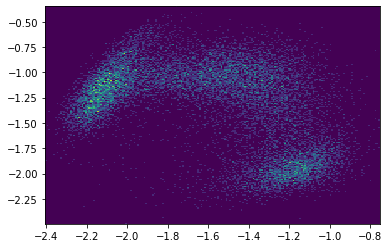

Plate: 55395990


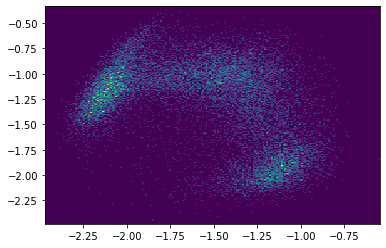

Plate: 55405991


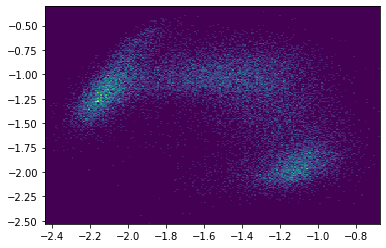

Plate: 75836284


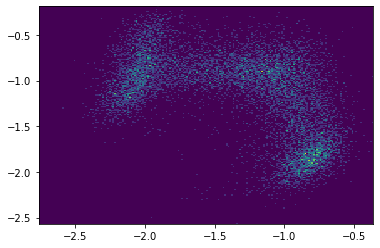

Plate: 75846286


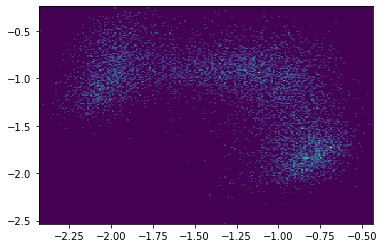

In [61]:
for uplate in np.unique(plate):
    print(f"Plate: {uplate}")
    plt.hist2d(np.log10(green_fucci[plate == uplate]), np.log10(red_fucci[plate == uplate]), bins=200)
    plt.show()
    plt.close()

## Thinking about batch corrections

It's particularly noticable if you look at the minimum edge. The minimum of the green fucci log intensities are quite different per plate

In [62]:
def zero_center_fucci(green_fucci, red_fucci, u_plate, well_plate, plate):
    '''Zero center and rescale FUCCI data in the log space'''
    log_green_fucci, log_red_fucci = np.log10(green_fucci), np.log10(red_fucci)
    wp_p_dict = dict([(str(p), plate == p) for p in u_plate])
    logmed_green_fucci_p = dict([(str(p), np.log10(np.median(green_fucci[wp_p_dict[str(p)]]))) for p in u_plate])
    logmed_red_fucci_p = dict([(str(p), np.log10(np.median(red_fucci[wp_p_dict[str(p)]]))) for p in u_plate])
    logmed_green_fucci = np.array([logmed_green_fucci_p[wp.split("_")[1]] for wp in well_plate])
    logmed_red_fucci = np.array([logmed_red_fucci_p[wp.split("_")[1]] for wp in well_plate])
    log_green_fucci_zeroc = np.array(log_green_fucci) - logmed_green_fucci
    log_red_fucci_zeroc = np.array(log_red_fucci) - logmed_red_fucci
    log_green_fucci_zeroc_rescale = (log_green_fucci_zeroc - np.min(log_green_fucci_zeroc)) / np.max(log_green_fucci_zeroc)
    log_red_fucci_zeroc_rescale = (log_red_fucci_zeroc - np.min(log_red_fucci_zeroc)) / np.max(log_red_fucci_zeroc)
    fucci_data = np.column_stack([log_green_fucci_zeroc_rescale,log_red_fucci_zeroc_rescale])
    result = (log_green_fucci, log_red_fucci,
              log_green_fucci_zeroc, log_red_fucci_zeroc,
              log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale,
              fucci_data)
    return result
log_green_fucci, log_red_fucci, log_green_fucci_zeroc, log_red_fucci_zeroc, log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale, fucci_data = zero_center_fucci(
    green_fucci, red_fucci, u_plate, well_plate, plate
)

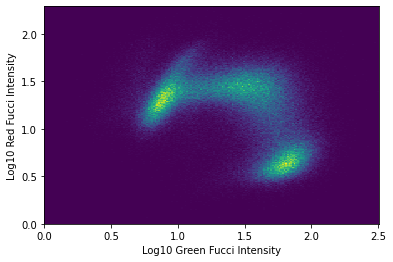

In [63]:
plt.hist2d(log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale, bins=200)
plt.xlabel("Log10 Green Fucci Intensity")
plt.ylabel("Log10 Red Fucci Intensity")
plt.savefig("figures/FucciPlotProteinIFData_unfiltered.png")
plt.show()
plt.close()

Plate: 6717


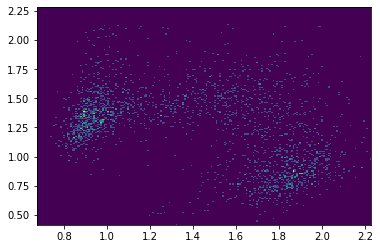

Plate: 6718


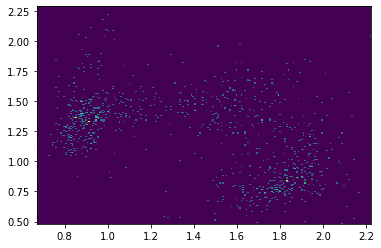

Plate: 6719


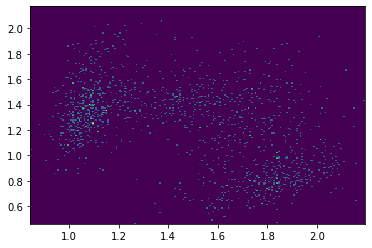

Plate: 6720


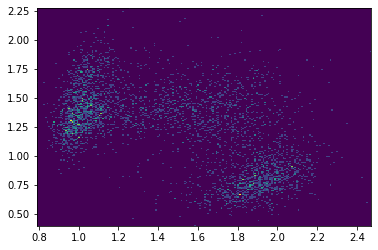

Plate: 6721


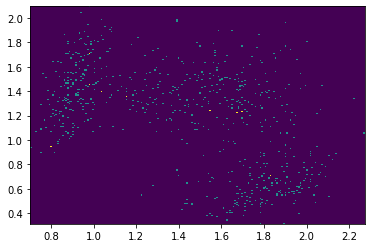

Plate: 6722


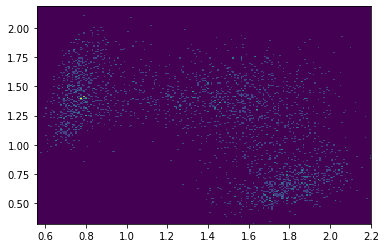

Plate: 6724


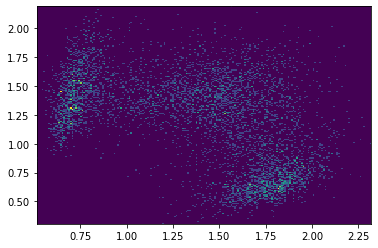

Plate: 6725


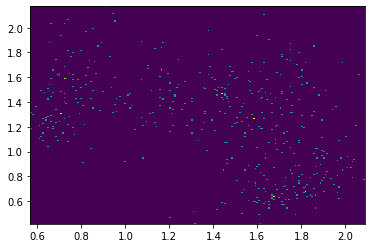

Plate: 6731


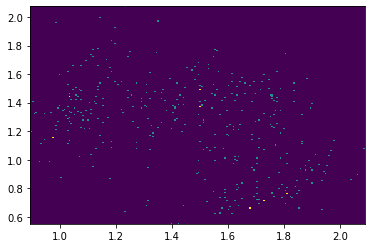

Plate: 6734


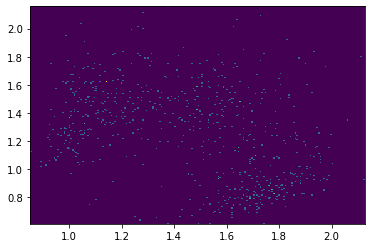

Plate: 6736


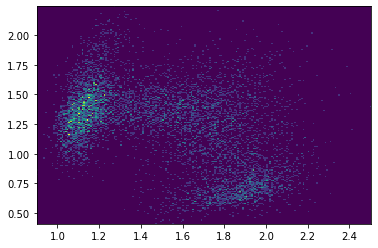

Plate: 6745


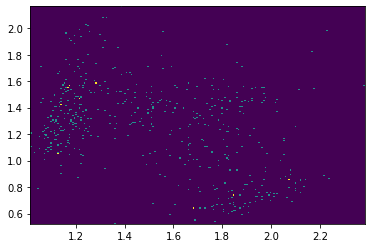

Plate: 55185977


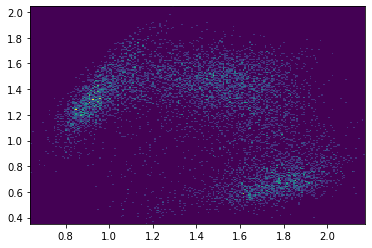

Plate: 55195978


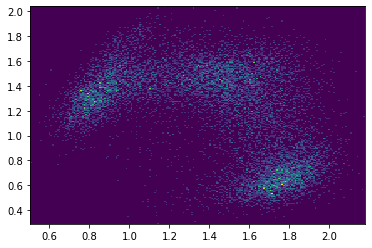

Plate: 55205980


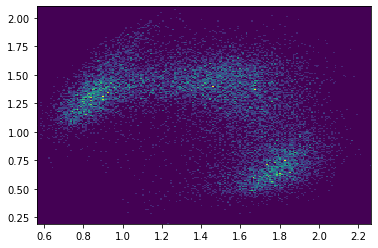

Plate: 55215982


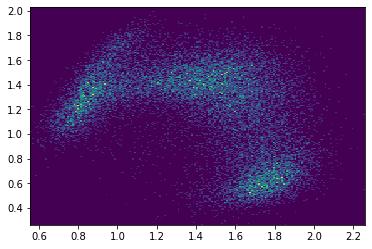

Plate: 55225983


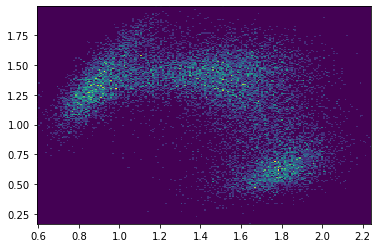

Plate: 55235979


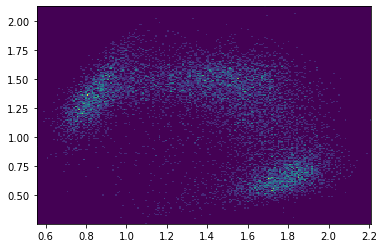

Plate: 55245981


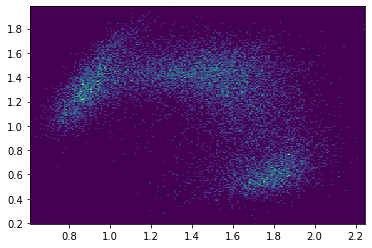

Plate: 55335984


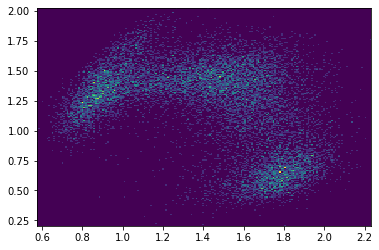

Plate: 55345985


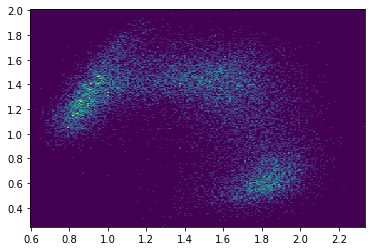

Plate: 55355986


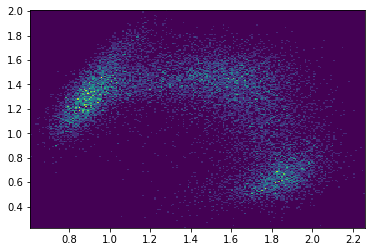

Plate: 55365987


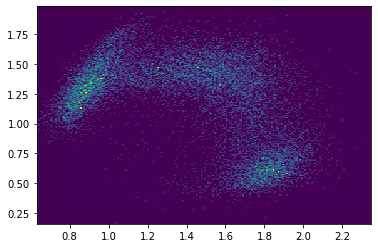

Plate: 55375988


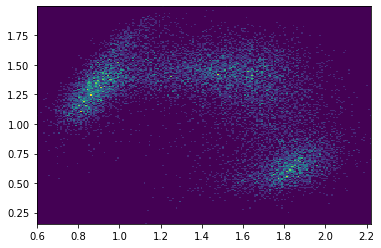

Plate: 55385989


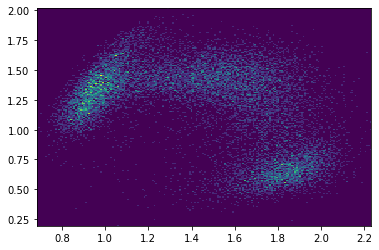

Plate: 55395990


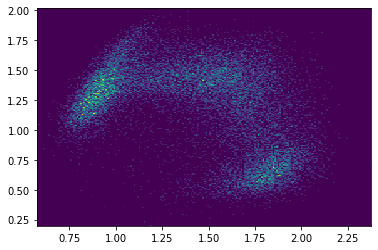

Plate: 55405991


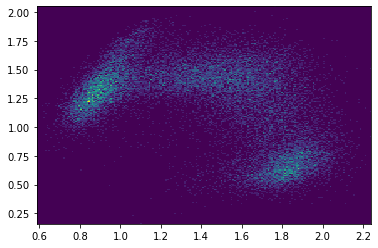

Plate: 75836284


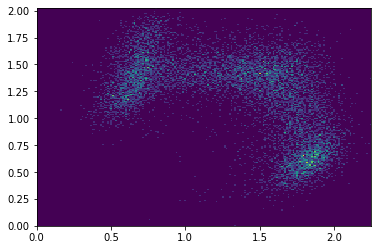

Plate: 75846286


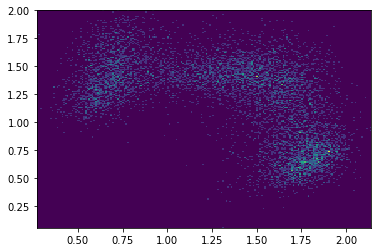

In [64]:
for uplate in np.unique(plate):
    print(f"Plate: {uplate}")
    plt.hist2d(log_green_fucci_zeroc_rescale[plate == uplate], log_red_fucci_zeroc_rescale[plate == uplate], bins=200)
    plt.show()
    plt.close()

## Batch correction fix justification

The lower boundary is still somewhat different, but the most noticable difference is the location of the centerpoint, which is important for the coming analysis.

It was anywhere from -2 to -1.5 in the log space before.

In this rescaled log space, it's consistently at about 1.4. This will be important for calculating pseudotime soon.

## Gaussian clustering of the data

Let's use some Gaussian clustering to see the three phases we expect from the data.

This analysis was used as a mock-up bulk analysis for each of the phases to compare the number of genes called cell cycle dependent to how many would be called from bulk.

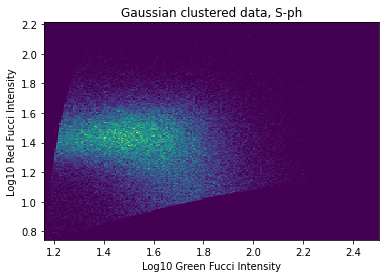

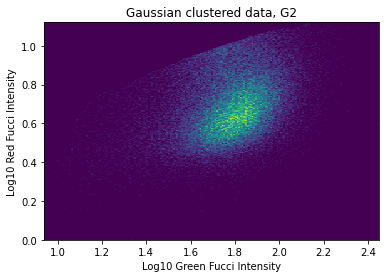

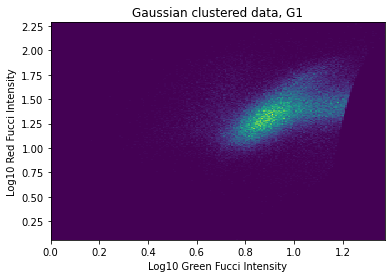

In [65]:
'''Perform gaussian clustering of FUCCI data into 3 phases: G1, S, G2'''
g1_idx, sph_idx, g2_idx = 2, 0, 1
clusternames = [
    "G2" if g2_idx == 0 else "G1" if g1_idx == 0 else "S-ph",
    "G2" if g2_idx == 1 else "G1" if g1_idx == 1 else "S-ph",
    "G2" if g2_idx == 2 else "G1" if g1_idx == 2 else "S-ph",
]

gaussian = sklearn.mixture.GaussianMixture(n_components=3, random_state=1, max_iter=500)
cluster_labels = gaussian.fit_predict(np.array([log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale]).T)
for cluster in range(3):
    plt.hist2d(log_green_fucci_zeroc_rescale[cluster_labels == cluster],log_red_fucci_zeroc_rescale[cluster_labels == cluster],bins=200)
    plt.title(f"Gaussian clustered data, {clusternames[cluster]}")
    plt.xlabel("Log10 Green Fucci Intensity")
    plt.ylabel("Log10 Red Fucci Intensity")
    plt.savefig(f"figures/FucciPlotProteinIFData_unfiltered_Gauss{cluster}.png")
    plt.show()
    plt.close()

def get_phase_strings(is_g1, is_sph, is_g2):
    '''Make strings to represent the metacompartment'''
    phasestring = np.array(["G1"] * len(is_g1))
    phasestring[is_sph] = "S" 
    phasestring[is_g2] = "G2"
    return phasestring

g1 = cluster_labels == g1_idx
sph = cluster_labels == sph_idx
g2 = cluster_labels == g2_idx
alpha_gauss, doGenerateBoxplotsPerGene = 0.05, False
wp_cell_kruskal, wp_nuc_kruskal, wp_cyto_kruskal, wp_mt_kruskal = [],[],[],[]
curr_wp_phases = []
mockbulk_phases = np.array(["  "] * len(ab_cell))
for iii, wp in enumerate(u_well_plates):
    curr_well_inds = well_plate==wp
    curr_wp_g1 = curr_well_inds & g1
    curr_wp_sph = curr_well_inds & sph
    curr_wp_g2 = curr_well_inds & g2
    curr_wp_phase_list = get_phase_strings(g1[curr_well_inds], sph[curr_well_inds], g2[curr_well_inds])
    mockbulk_phases[curr_well_inds] = np.asarray(curr_wp_phase_list)
    curr_wp_phases.append(curr_wp_phase_list)
    max_val_for_norm = np.max(ab_cell[curr_well_inds] if wp_iscell[iii] else ab_nuc[curr_well_inds] if wp_isnuc[iii] else ab_cyto[curr_well_inds])
    max_mt_for_norm = np.max(mt_cell[curr_well_inds])



## Calculating a pseudotime based on markers for the cell cycle

In [66]:
## First, some setup:

class FucciCellCycle:
    '''
    Object representing the length of the FUCCI cell cycle phase transitions, which
    were manually determined by Diana M.
    '''
    def __init__(self):
        # Length of the cell cycle observed for the FUCCI cell line
        self.G1_LEN = 10.833 #hours (plus 10.833, so 13.458hrs for the S/G2 cutoff)
        self.G1_S_TRANS = 2.625 #hours (plus 10.833 and 2.625 so 25.433 hrs for the G2/M cutoff)
        self.S_G2_LEN = 11.975 #hours (this should be from the G2/M cutoff above to the end)
        self.M_LEN = 0.5 # We excluded M-phase from this analysis

        self.TOT_LEN = self.G1_LEN+self.G1_S_TRANS+self.S_G2_LEN

        self.G1_PROP = self.G1_LEN / self.TOT_LEN
        self.G1_S_PROP = self.G1_S_TRANS / self.TOT_LEN + self.G1_PROP
        self.S_G2_PROP = self.S_G2_LEN / self.TOT_LEN + self.G1_S_PROP

NBINS_POLAR_COORD = 150 # Number of bins for polar coord calculation, arbitrary choice for now
WINDOW_FUCCI_PSEUDOTIME = 100 # Window used for visualizing FUCCI intensities over pseudotime
fucci = FucciCellCycle() # Object representing FUCCI cell cycle phase durations

## POLAR COORDINATE FUNCTIONS
def calc_R(xc, yc, x, y):
    '''Calculate the distance of each 2D points from the center (xc, yc)'''
    return np.sqrt((x-xc)**2 + (y-yc)**2)
def f_2(c,x,y):
    '''Calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)'''
    print(c)
    Ri = calc_R(c[0],c[1],x,y)
    return Ri - Ri.mean()
def cart2pol(x, y):
    '''Convert cartesian coordinates to polar coordinates'''
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol_sort(inds, more_than_start, less_than_start, *args):
    '''Sort data by polar coordinates and reorder based on the start position of the polar coordinate model'''
    return [np.concatenate((arr[inds][more_than_start], arr[inds][less_than_start])) for arr in args]
def pol2cart(rho, phi):
    '''Apply uniform radius (rho) and convert back'''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


## PLOTTING HELPERS
def plot_annotate_time(R_2, start_phi, fraction):
    '''Pseudotime annotation helper for point on plot'''
    pt = pol2cart(R_2,start_phi + (1 - fraction) * 2 * np.pi)
    plt.scatter(pt[0],pt[1],c='c',linewidths=4)
    plt.annotate(f"  {round(fraction * fucci.TOT_LEN, 2)} hrs", (pt[0], pt[1]))
    
def drange(x, y, jump):
    '''Increment `x` by a decimal `jump` until greater than `y`'''
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

def fucci_hist2d(centered_data, cart_data_ur, start_pt, g1_end_pt, g1s_end_pt, analysis_title, R_2, start_phi, nbins=200,
        show_gmnn = False, pol_sort_well_plate = [], pol_sort_ab_nuc = [], pol_sort_centered_data0 = [], pol_sort_centered_data1 = []):
    '''
    Visualize the log-FUCCI intensities and phase transitions.
    If `show_gmnn` is true, generate an overlay of the GMNN antibody staining intensities.
    '''
    fig, ax1 = plt.subplots(figsize=(10,10))
    mycmap = copy.copy(plt.cm.get_cmap("gray_r"))
    mycmap.set_under(color='w',alpha=None)
    ax1.hist2d(centered_data[:,0],centered_data[:,1],bins=nbins,alpha=1,cmap=mycmap)
    hist, xbins, ybins = np.histogram2d(cart_data_ur[0], cart_data_ur[1], bins=nbins, density=True)
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]
    im = ax1.imshow(
            np.ma.masked_where(hist == 0, hist).T,
            interpolation='nearest',
            origin='lower',
            extent=extent,
            cmap='plasma')
    if show_gmnn: # GMNN was tagged in the FUCCI cells and stained with antibodies; visualize the agreement
        gmnn = "H05_55405991"
        gmnn_well_inds = pol_sort_well_plate==gmnn
        gmnn_ab_nuc = pol_sort_ab_nuc[gmnn_well_inds]
        im = ax1.scatter(pol_sort_centered_data0[gmnn_well_inds],pol_sort_centered_data1[gmnn_well_inds], c=gmnn_ab_nuc)
        fig.colorbar(im, ax=ax1)
    else:
        plt.scatter(start_pt[0],start_pt[1],c='c',linewidths=4)
        plt.scatter(g1_end_pt[0],g1_end_pt[1],c='c',linewidths=4)
        plt.scatter(g1s_end_pt[0],g1s_end_pt[1],c='c',linewidths=4)
        plt.scatter(0,0,c='m',linewidths=4)
        plt.annotate("  0 hrs (start)", (start_pt[0],start_pt[1]))
        plt.annotate(f"  {fucci.G1_LEN} hrs (end of G1)", (g1_end_pt[0],g1_end_pt[1]))
        plt.annotate(f"  {fucci.G1_LEN + fucci.G1_S_TRANS} hrs (end of S)", (g1s_end_pt[0],g1s_end_pt[1]))
        for yeah in list(drange(decimal.Decimal(0.1), 0.9, '0.1')):
            plot_annotate_time(R_2, start_phi, yeah)
    plt.xlabel(r'$\propto log_{10}(GMNN_{fucci})$',size=20)
    plt.ylabel(r'$\propto log_{10}(CDT1_{fucci})$',size=20)
    plt.tight_layout()
    if show_gmnn:
        plt.savefig('figures/GMNN_FUCCI_plot.pdf', transparent=True)
    else:
        plt.savefig(f'figures/masked_polar_hist_{analysis_title}.pdf', transparent=True)
    plt.show()
    plt.close()

## STRETCH TIME
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i = round(i + step, 14)

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1), np.arange(npt), np.sort(x))

def histedges_equalA(x, nbin):
    pow = 0.5
    dx = np.diff(np.sort(x))
    tmp = np.cumsum(dx ** pow)
    tmp = np.pad(tmp, (1, 0), 'constant')
    return np.interp(np.linspace(0, tmp.max(), nbin + 1), tmp, np.sort(x))

def stretch_time(time_data,nbins=1000):
    '''This function is supposed to create uniform density space'''
    n, bins, patches = plt.hist(time_data, histedges_equalN(time_data, nbins), density=True)
    tmp_time_data = deepcopy(time_data)
    trans_time = np.zeros([len(time_data)])
    
    # Get bin indexes
    for i,c_bin in enumerate(bins[1:]):
        c_inds = np.argwhere(tmp_time_data<c_bin)
        trans_time[c_inds] = i/nbins
        tmp_time_data[c_inds] = np.inf
    return trans_time

In [67]:
def fucci_polar_coords(x, y, analysis_title):
    '''
    Calculate the polar coordinate position of each cell based on the FUCCI intensities (x, y).
    '''
    fucci_data = np.column_stack([x, y])
    center_est_xy = np.mean(x), np.mean(y)
    center_est2_xy = scipy.optimize.least_squares(f_2, center_est_xy, args=(x, y))
    xc_2, yc_2 = center_est2_xy.x
    Ri_2       = calc_R(*center_est2_xy.x,x,y)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)

    # Center data
    centered_data = fucci_data - center_est2_xy.x

    pol_data = cart2pol(centered_data[:,0],centered_data[:,1])
    pol_sort_inds = np.argsort(pol_data[1])
    pol_sort_rho = pol_data[0][pol_sort_inds]
    pol_sort_phi = pol_data[1][pol_sort_inds]
    centered_data_sort0 = centered_data[pol_sort_inds,0]
    centered_data_sort1 = centered_data[pol_sort_inds,1]

    # Rezero to minimum --resoning, cells disappear during mitosis, so we should have the fewest detected cells there
    bins = plt.hist(pol_sort_phi,NBINS_POLAR_COORD)
    start_phi = bins[1][np.argmin(bins[0])]

    # Move those points to the other side
    more_than_start = np.greater(pol_sort_phi,start_phi)
    less_than_start = np.less_equal(pol_sort_phi,start_phi)
    pol_sort_rho_reorder = np.concatenate((pol_sort_rho[more_than_start],pol_sort_rho[less_than_start]))
    pol_sort_inds_reorder = np.concatenate((pol_sort_inds[more_than_start],pol_sort_inds[less_than_start]))
    pol_sort_phi_reorder = np.concatenate((pol_sort_phi[more_than_start],pol_sort_phi[less_than_start]+np.pi*2))
    pol_sort_centered_data0 = np.concatenate((centered_data_sort0[more_than_start],centered_data_sort0[less_than_start]))
    pol_sort_centered_data1 = np.concatenate((centered_data_sort1[more_than_start],centered_data_sort1[less_than_start]))
    pol_sort_shift = pol_sort_phi_reorder+np.abs(np.min(pol_sort_phi_reorder))

    # Shift and re-scale "time"
    # reverse "time" since the cycle goes counter-clockwise wrt the fucci plot
    pol_sort_norm = pol_sort_shift/np.max(pol_sort_shift)
    pol_sort_norm_rev = 1 - pol_sort_norm 
    pol_sort_norm_rev = stretch_time(pol_sort_norm_rev)
    plt.tight_layout()
    plt.savefig(f"figures/FucciAllPseudotimeHist_{analysis_title}.png")
    # plt.show()
    plt.close()

    # visualize that result
    start_pt = pol2cart(R_2,start_phi)
    g1_end_pt = pol2cart(R_2,start_phi + (1 - fucci.G1_PROP) * 2 * np.pi)
    g1s_end_pt = pol2cart(R_2,start_phi + (1 - fucci.G1_S_PROP) * 2 * np.pi)
    cart_data_ur = pol2cart(np.repeat(R_2,len(centered_data)), pol_data[1])
    fucci_hist2d(centered_data, cart_data_ur, start_pt, g1_end_pt, g1s_end_pt, analysis_title, R_2, start_phi)

    return (pol_sort_norm_rev, centered_data, pol_sort_centered_data0, pol_sort_centered_data1, pol_sort_phi, pol_sort_inds, pol_sort_inds_reorder, pol_sort_phi_reorder,
        more_than_start, less_than_start, start_pt, g1_end_pt, g1s_end_pt, cart_data_ur, R_2, start_phi)

[1.41875375 1.19453237]
[1.41875377 1.19453237]
[1.41875375 1.19453239]
[1.35346793 1.04313123]
[1.35346796 1.04313123]
[1.35346793 1.04313125]
[1.32086659 0.98971763]
[1.32086661 0.98971763]
[1.32086659 0.98971765]
[1.31163352 0.97607828]
[1.31163354 0.97607828]
[1.31163352 0.9760783 ]
[1.30953783 0.97307393]
[1.30953785 0.97307393]
[1.30953783 0.97307394]
[1.30909419 0.97245368]
[1.30909421 0.97245368]
[1.30909419 0.9724537 ]
[1.30900214 0.97232626]
[1.30900216 0.97232626]
[1.30900214 0.97232627]
[1.30898312 0.97230006]
[1.30898314 0.97230006]
[1.30898312 0.97230008]
[1.30897919 0.97229468]
[1.30897921 0.97229468]
[1.30897919 0.97229469]


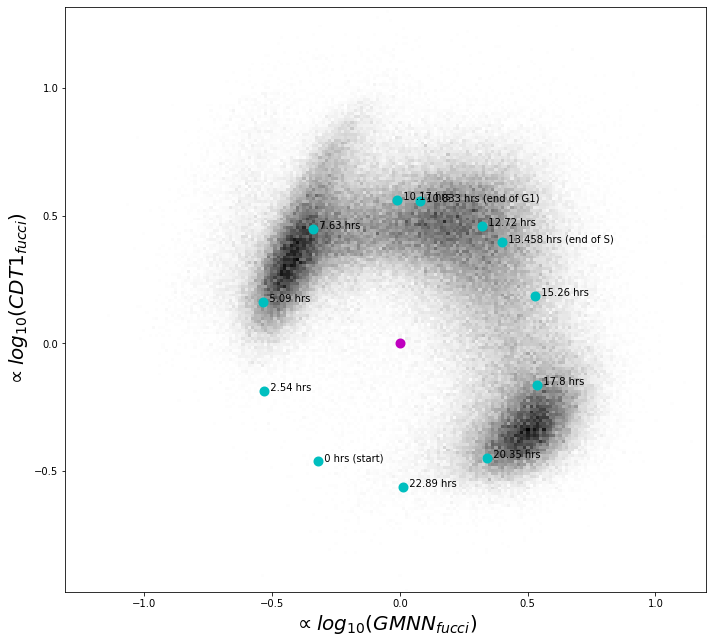

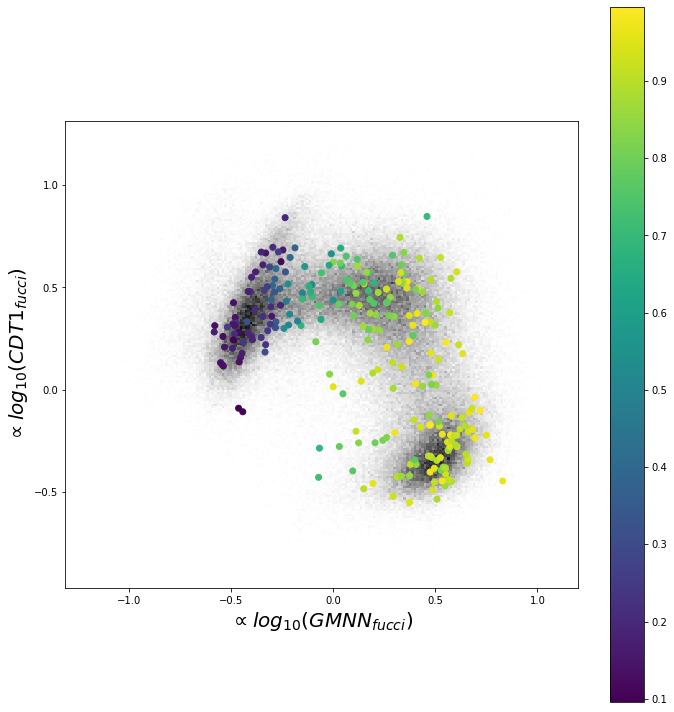

In [74]:
# Generate model
polar_coord_results = fucci_polar_coords(fucci_data[:,0], fucci_data[:,1], "Protein")
pol_sort_norm_rev, centered_data, pol_sort_centered_data0, pol_sort_centered_data1, pol_sort_phi, pol_sort_inds, pol_sort_inds_reorder, pol_sort_phi_reorder, more_than_start, less_than_start, start_pt, g1_end_pt, g1s_end_pt, cart_data_ur, R_2, start_phi = polar_coord_results

# Sort results by pseudotime
sort_results = pol_sort(pol_sort_inds, more_than_start, less_than_start, well_plate, well_plate_imgnb, well_plate_imgnb_objnb, np.asarray(ab_nuc), np.asarray(ab_cyto), np.asarray(ab_cell), np.asarray(mt_cell), np.asarray(area_cell), np.asarray(area_nuc), log_red_fucci_zeroc_rescale, log_green_fucci_zeroc_rescale, mockbulk_phases)
pol_sort_well_plate, pol_sort_well_plate_imgnb, pol_sort_well_plate_imgnb_objnb, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_ab_cell, pol_sort_mt_cell, pol_sort_area_cell, pol_sort_area_nuc, pol_sort_fred, pol_sort_fgreen, pol_sort_mockbulk_phases = sort_results
    
# Generate some plots
fucci_hist2d(centered_data, cart_data_ur, start_pt, g1_end_pt, g1s_end_pt, "Protein", R_2, start_phi, 200, True, pol_sort_well_plate, pol_sort_ab_nuc, pol_sort_centered_data0, pol_sort_centered_data1)
    

# We now have calculated a pseudotime for each cell!

Multiply that by 25.3 hrs for each division, and you have the actual time within the cell division cycle for each cell, along with some protein expression information

## What is the error in the cell cycle time determination?

Let's plot the marker expression over cell cycle time to figure out:

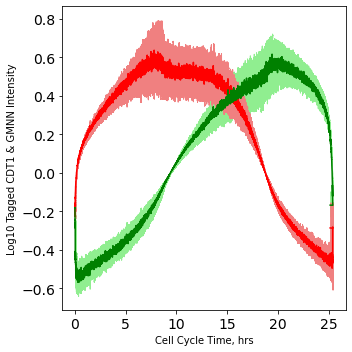

In [ ]:
def mvavg(yvals, mv_window):
    '''Calculate the moving average'''
    return np.convolve(yvals, np.ones((mv_window,))/mv_window, mode='valid')
def mvpercentiles(yvals_binned):
    '''Calculate moving percentiles given moving-window binned values'''
    return np.percentile(yvals_binned, [10, 25, 50, 75, 90], axis=1)

def plot_fucci_intensities_on_pseudotime(pol_sort_norm_rev, pol_sort_centered_data1, pol_sort_centered_data0):
    '''Visualize FUCCI intensities over pseudotime'''
    plt.figure(figsize=(5,5))
    WINDOW_FUCCI_PSEUDOTIMEs = np.asarray([np.arange(start, start + WINDOW_FUCCI_PSEUDOTIME) for start in np.arange(len(pol_sort_norm_rev) - WINDOW_FUCCI_PSEUDOTIME + 1)])
    mvperc_red = mvpercentiles(pol_sort_centered_data1[WINDOW_FUCCI_PSEUDOTIMEs])
    mvperc_green = mvpercentiles(pol_sort_centered_data0[WINDOW_FUCCI_PSEUDOTIMEs])
    mvavg_xvals = mvavg(pol_sort_norm_rev, WINDOW_FUCCI_PSEUDOTIME)
    plt.fill_between(mvavg_xvals * fucci.TOT_LEN, mvperc_green[1], mvperc_green[-2], color="lightgreen", label="25th & 75th Percentiles")
    plt.fill_between(mvavg_xvals * fucci.TOT_LEN, mvperc_red[1], mvperc_red[-2], color="lightcoral", label="25th & 75th Percentiles")
    
    mvavg_red = mvavg(pol_sort_centered_data1, WINDOW_FUCCI_PSEUDOTIME)
    mvavg_green = mvavg(pol_sort_centered_data0, WINDOW_FUCCI_PSEUDOTIME)
    plt.plot(mvavg_xvals * fucci.TOT_LEN, mvavg_red, color="r", label="Mean Intensity")
    plt.plot(mvavg_xvals * fucci.TOT_LEN, mvavg_green, color="g", label="Mean Intensity")
    plt.xlabel('Cell Cycle Time, hrs')
    plt.ylabel('Log10 Tagged CDT1 & GMNN Intensity')
    plt.xticks(size=14)
    plt.yticks(size=14)
    # plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("figures/FUCCIOverPseudotime.pdf")
    plt.savefig("figures/FUCCIOverPseudotime.png")
    plt.show()
    plt.close()
plot_fucci_intensities_on_pseudotime(pol_sort_norm_rev, pol_sort_centered_data1, pol_sort_centered_data0)

## Discussion:

The 25th and 75th percentiles of the marker intensity shown by the light colored ranges are fairly tight over the whole cell cycle, indicating the error is acceptable for cell cycle determination.

## Taking a look at a cycling protein

One of the most interesting cycling proteins we found was UGDH, which is not regulated at the transcriptional level and is a newly discovered cycling protein.

We also used live-cell imaging to reveal that this protein is translocating between the cytosol to the nucleus over the cell cycle.

![ugdh](ugdh.png "UGDH")

Let's make a plot to display the expression of UGDH over the cell cycle.

In [ ]:
class FucciCellCycle:
    '''
    Object representing the length of the FUCCI cell cycle phase transitions, which
    were manually determined by Diana M.
    '''
    def __init__(self):
        # Length of the cell cycle observed for the FUCCI cell line
        self.G1_LEN = 10.833 #hours (plus 10.833, so 13.458hrs for the S/G2 cutoff)
        self.G1_S_TRANS = 2.625 #hours (plus 10.833 and 2.625 so 25.433 hrs for the G2/M cutoff)
        self.S_G2_LEN = 11.975 #hours (this should be from the G2/M cutoff above to the end)
        self.M_LEN = 0.5 # We excluded M-phase from this analysis

        self.TOT_LEN = self.G1_LEN+self.G1_S_TRANS+self.S_G2_LEN

        self.G1_PROP = self.G1_LEN / self.TOT_LEN
        self.G1_S_PROP = self.G1_S_TRANS / self.TOT_LEN + self.G1_PROP
        self.S_G2_PROP = self.S_G2_LEN / self.TOT_LEN + self.G1_S_PROP

In [ ]:
np.random.seed(0) # Get the same results each time
WINDOW = 10 # Number of points for moving average window for protein analysis
WINDOW_FUCCI_MARKERS = 100 # Used for getting median FUCCI marker intensity for LASSO analysis
PERMUTATIONS = 10000 # Number of permutations used for randomization analysis
MIN_MEAN_PERCVAR_DIFF_FROM_RANDOM = 0.08 # Cutoff used for percent additional variance explained by the cell cycle than random
BINS_FOR_UMAP_AND_LASSO = 400 # Number of bins for creating UMAPs/LASSO model. Chosen for the best stability.
chosen_cutoff = MIN_MEAN_PERCVAR_DIFF_FROM_RANDOM

def permutation_analysis_protein(idx, curr_pol, curr_ab_cell_norm, curr_ab_nuc_norm, curr_ab_cyto_norm, curr_mt_cell_norm,
        perc_var_cell_val, perc_var_nuc_val, perc_var_cyto_val,
        wp_iscell, wp_isnuc, wp_iscyto,
        mvavg_cell, mvavg_nuc, mvavg_cyto):
    '''Randomization analysis of cell cycle dependence: permute cell order and calculate percent variance due to the cell cycle'''
    perms = np.asarray([np.random.permutation(len(curr_pol)) for nnn in np.arange(PERMUTATIONS)])
    curr_comp_norm = np.asarray(curr_ab_cell_norm if wp_iscell[idx] else curr_ab_nuc_norm if wp_isnuc[idx] else curr_ab_cyto_norm)
    curr_comp_percvar = np.asarray(perc_var_cell_val if wp_iscell[idx] else perc_var_nuc_val if wp_isnuc[idx] else perc_var_cyto_val)
    curr_comp_mvavg = np.asarray(mvavg_cell if wp_iscell[idx] else mvavg_nuc if wp_isnuc[idx] else mvavg_cyto)
    curr_comp_perm = np.asarray([curr_comp_norm[perm] for perm in perms])
    curr_mt_perm = np.asarray([curr_mt_cell_norm[perm] for perm in perms])
    curr_mvavg_rng_comp = np.apply_along_axis(mvavg, 1, curr_comp_perm, WINDOW)
    curr_mvavg_rng_mt = np.apply_along_axis(mvavg, 1, curr_mt_perm, WINDOW)
    curr_percvar_rng_comp = np.var(curr_mvavg_rng_comp, axis=1) / np.var(curr_comp_perm, axis=1)
    curr_percvar_rng_mt = np.var(curr_mvavg_rng_mt, axis=1) / np.var(curr_mt_perm, axis=1)
    return (curr_comp_norm, curr_comp_percvar, curr_comp_mvavg, curr_comp_perm, curr_mt_perm, 
        curr_mvavg_rng_comp, curr_mvavg_rng_mt, curr_percvar_rng_comp, curr_percvar_rng_mt)

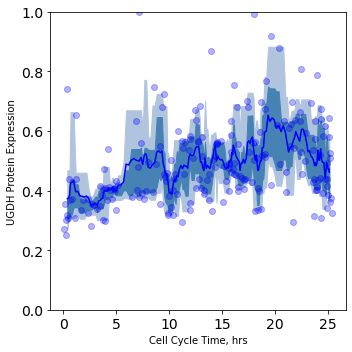

In [92]:
def mvmed(yvals_binned):
    '''Calculate the moving median given moving-window binned values'''
    return np.median(yvals_binned, axis=1)
def mvmed_perc_var(yvals, windows):
    '''Calculate moving median and the percent variance that can be attributed to the cell cycle'''
    yval_avg = mvmed(yvals[windows])
    return np.var(yval_avg) / np.var(yvals), yval_avg
def mvavg_perc_var(yvals,mv_window):
    '''Calculate moving average and the percent variance that can be attributed to cell cycle'''
    yval_avg = np.convolve(yvals,np.ones((mv_window,))/mv_window, mode='valid')
    return np.var(yval_avg)/np.var(yvals), yval_avg
    
def remove_outliers_idx(values):
    '''Returns indices of outliers to keep'''
    max_cutoff = np.mean(values) + 2 * np.std(values)
    min_cutoff = np.mean(values) - 2 * np.std(values)
    return (values < max_cutoff) & (values > min_cutoff)

def remove_outliers(values, return_values):
    '''Remove outliers on "values" and return "return_values" based on that filter'''
    return return_values[remove_outliers_idx(values)]

def temporal_mov_avg_protein(curr_pol, curr_ab_norm, mvavg_xvals, mvavg_yvals, mvperc, clusters, fileprefix):
    '''
    Generates a moving average plot for one protein
    Input: Antibody intensity measurements for the current protein
    Output: Moving average plot with scatter of protein abundance measurement for each cell over the cell cycle
    '''
    plt.close()
    plt.figure(figsize=(5,5))
    fucci=FucciCellCycle()
    plt.fill_between(mvavg_xvals * fucci.TOT_LEN, mvperc[0], mvperc[-1], color="lightsteelblue", label="10th & 90th Percentiles")
    plt.fill_between(mvavg_xvals * fucci.TOT_LEN, mvperc[1], mvperc[-2], color="steelblue", label="25th & 75th Percentiles")
    plt.plot(mvavg_xvals * fucci.TOT_LEN, mvavg_yvals, color="blue", label="Mean Intensity")
    plt.scatter(curr_pol * fucci.TOT_LEN, curr_ab_norm, c=(clusters if clusters is not None else 'b'), cmap="bwr_r" if clusters is not None else None, alpha=0.3)
    plt.xlabel('Cell Cycle Time, hrs')
    plt.ylabel(fileprefix + ' Protein Expression')
    plt.xticks(size=14)
    plt.yticks(size=14)
#    plt.legend(fontsize=14)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    plt.close()

ugdh_well = "D02_55215982"
i=np.arange(len(u_well_plates))[u_well_plates == ugdh_well]
curr_well_inds = pol_sort_well_plate==ugdh_well
curr_pol = pol_sort_norm_rev[curr_well_inds]
curr_ab_cell = pol_sort_ab_cell[curr_well_inds]
curr_ab_nuc = pol_sort_ab_nuc[curr_well_inds]
curr_ab_cyto = pol_sort_ab_cyto[curr_well_inds]
curr_mt_cell = pol_sort_mt_cell[curr_well_inds]
curr_fred = pol_sort_fred[curr_well_inds]
curr_fgreen = pol_sort_fgreen[curr_well_inds]
curr_mockbulk_phase = pol_sort_mockbulk_phases[curr_well_inds]

# Remove outliers
curr_comp = curr_ab_cell if wp_iscell[i] else curr_ab_nuc if wp_isnuc[i] else curr_ab_cyto
curr_pol = remove_outliers(curr_comp, curr_pol)
curr_ab_cell = remove_outliers(curr_comp, curr_ab_cell)
curr_ab_nuc = remove_outliers(curr_comp, curr_ab_nuc)
curr_ab_cyto = remove_outliers(curr_comp, curr_ab_cyto)
curr_mt_cell = remove_outliers(curr_comp, curr_mt_cell)
curr_fred = remove_outliers(curr_comp, curr_fred)
curr_fgreen = remove_outliers(curr_comp, curr_fgreen)
curr_mockbulk_phase = remove_outliers(curr_comp, curr_mockbulk_phase)

# Normalize mean intensities, normalized for display
curr_ab_cell_norm = curr_ab_cell / np.max(curr_ab_cell) 
curr_ab_nuc_norm = curr_ab_nuc / np.max(curr_ab_nuc)
curr_ab_cyto_norm = curr_ab_cyto / np.max(curr_ab_cyto) 
curr_mt_cell_norm  = curr_mt_cell / np.max(curr_mt_cell)

# Original method from Devin's work
perc_var_cell_val, mvavg_cell = mvavg_perc_var(curr_ab_cell_norm, WINDOW)
perc_var_nuc_val, mvavg_nuc = mvavg_perc_var(curr_ab_nuc_norm, WINDOW)
perc_var_cyto_val, mvavg_cyto = mvavg_perc_var(curr_ab_cyto_norm, WINDOW)
perc_var_mt_val, mvavg_mt = mvavg_perc_var(curr_mt_cell_norm, WINDOW)
mvavg_xvals = mvavg(curr_pol, WINDOW)

# Permutation analysis
permutation_result = permutation_analysis_protein(i, 
                            curr_pol, curr_ab_cell_norm, curr_ab_nuc_norm, curr_ab_cyto_norm, curr_mt_cell_norm,
                            perc_var_cell_val, perc_var_nuc_val, perc_var_cyto_val, 
                            wp_iscell, wp_isnuc, wp_iscyto, 
                            mvavg_cell, mvavg_nuc, mvavg_cyto)
curr_comp_norm, curr_comp_percvar, curr_comp_mvavg, curr_comp_perm, curr_mt_perm, curr_mvavg_rng_comp, curr_mvavg_rng_mt, curr_percvar_rng_comp, curr_percvar_rng_mt = permutation_result
mvavg_comp = mvavg_cell if wp_iscell[i] else mvavg_nuc if wp_isnuc[i] else mvavg_cyto
curr_ab_norm = curr_ab_cell_norm if wp_iscell[i] else curr_ab_nuc_norm if wp_isnuc[i] else curr_ab_cyto_norm
windows = np.asarray([np.arange(start, start + WINDOW) for start in np.arange(len(curr_pol) - WINDOW + 1)])
mvavg_comp = mvavg_nuc
curr_ab_norm = curr_ab_nuc_norm

windows = np.asarray([np.arange(start, start + WINDOW) for start in np.arange(len(curr_pol) - WINDOW + 1)])
mvperc_comp = mvpercentiles(curr_ab_norm[windows])

temporal_mov_avg_protein(curr_pol, curr_ab_norm, mvavg_xvals, mvavg_comp, mvperc_comp, None, "UGDH")